In [9]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
import pandas as pd

class TranslateDataset(Dataset):
    def __init__(self, x, y, src_tokenizer, tgt_tokenizer):
        self.x = x
        self.y = y
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

    def collate_fn(self, batch):
        batch_x, batch_y = zip(*batch)
        inputs = self.src_tokenizer(batch_x, max_length=256, truncation=True, padding="longest", return_tensors='pt').input_ids[:, 1:]
        targets = self.tgt_tokenizer(batch_y, max_length=256, truncation=True, padding="longest", return_tensors='pt').input_ids

        return {'src_input_ids':inputs, 'tgt_input_ids': targets}

df = pd.read_csv('translate.csv')
input_texts = df['chinese'].values
target_texts = df['english'].values
x_train, x_valid, y_train, y_valid = train_test_split(input_texts, target_texts, train_size=0.8, random_state=46, shuffle=True)

src_tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
tgt_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

trainset = TranslateDataset(x_train, y_train, src_tokenizer, tgt_tokenizer)
validset = TranslateDataset(x_valid, y_valid, src_tokenizer, tgt_tokenizer)

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=validset.collate_fn)


In [10]:
import torch.nn as nn

class EncoderGRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, padding_idx):
        super(EncoderGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=padding_idx)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)

    def forward(self, token_ids):
        embedded = self.dropout(self.embedding(token_ids))
        #embedded: (batch_size, time_step, emb_dim)
        output, hidden = self.gru(embedded)
        # output: (batch_size, time_step, hidden_size * 2)
        # hidden: (2, batch_size, hidden_size)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.encoder_projection = nn.Linear(hidden_size, hidden_size)
        self.decoder_projection = nn.Linear(hidden_size, hidden_size)
        self.attention_v = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, encoder_hidden, decoder_hidden):
        energy = self.tanh(self.encoder_projection(encoder_hidden) + self.decoder_projection(decoder_hidden))
        #energy: (batch_size, time_step, hidden_size)
        scores = self.attention_v(energy)
        #scores: (batch_size, time_step, 1)
        scores = scores.squeeze(2).unsqueeze(1)
        #scores: (batch_size, 1, time_step)

        attention_weights = self.softmax(scores)
        # attention_weights (batch_size, 1, time_step)
        context_vector = torch.bmm(attention_weights, decoder_hidden)
        #context_vector: (batch_size, 1, hidden_size)
        return context_vector

class DecoderGRU(nn.Module):
    def __init__(self, attention, hidden_size, output_size, padding_idx):
        super(DecoderGRU, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=padding_idx)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.output_projection = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.attention = attention


    def forward(self, encoder_outputs, decoder_hidden, decoder_input_ids):
        # decoder_input_ids: (batch_size, 1)
        embedded = self.dropout(self.embedding(decoder_input_ids))
        # embedded: (1, batch_size, emb_dim)
        decoder_state = decoder_hidden.permute(1, 0, 2)
        #decoder_state (batch_size, 1, emb_dim)
        context = self.attention(decoder_state, encoder_outputs)
        # (batch_size, 1, hidden_size)
        input_gru = torch.cat((embedded, context), dim=-1)
        # input_gru (batch_size, 1, hidden_size + emb_dim)
        output, decoder_hidden = self.gru(input_gru, decoder_hidden)
        # output: (batch_size, time_step, hidden_size)
        # decoder_hidden: (1, batch_size, hidden_size)
        decoder_output = self.output_projection(output)
        # decoder_output: (batch_size, 1, output_size)
        return decoder_output, decoder_hidden


In [11]:
class Attentionseq2seq(nn.Module):
    def __init__(self, encoder, decoder, padding_idx):
        super(Attentionseq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.criterion = nn.NLLLoss(ignore_index=padding_idx)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, src_input_ids, tgt_input_ids):
        input_ids = src_input_ids
        targets = tgt_input_ids

        # Encoder
        encoder_outputs, decoder_hidden = self.encoder(input_ids)
        # encoder_outputs: (batch_size, time_step, hidden_size)
        # decoder_hidden: (1, batch_size, hidden_size)
        decoder_next_input = torch.empty(targets.shape[0], 1, dtype=torch.long).fill_(101).to(input_ids.device.type) # 加入CLS token
        # decoder_next_input: (batch_size, 1)

        # Decoder
        decoder_outputs = []
        for i in range(targets.shape[1]):
            decoder_next_input, decoder_hidden = self.decoder(encoder_outputs, decoder_hidden, decoder_next_input)
            # decoder_next_input: (batch_size, 1, hidden_size)
            # decoder_hidden: (1, batch_size, hidden_size)

            decoder_outputs.append(decoder_next_input)      # 儲存當前時序的文字分布狀態
            decoder_next_input = targets[:, i].unsqueeze(1) # 取出下一個對應的文字進行生成
            # decoder_next_input: (batch_size, 1)

        decoder_outputs = torch.cat(decoder_outputs, dim=1) # 完整的Decoder隱狀態輸出
        # decoder_outputs: (batch_size, time_step, output_dim)
        decoder_outputs = self.logsoftmax(decoder_outputs)  # 計算個文字機率
        # decoder_outputs: (batch_size, time_step, output_dim)

        # 計算損失值
        loss = self.criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), # (batch_size * time_step,  output_dim)
            targets.view(-1) # (batch_size * time_step)
        )

        return loss, decoder_outputs

    def generate(self, input_ids, sos_token=101, eos_token=102, max_len=50):
        with torch.no_grad():
            encoder_outputs, decoder_hidden = self.encoder(input_ids)
            decoder_outputs = []
            decoder_next_input = torch.empty(1, 1, dtype=torch.long).fill_(sos_token).to(input_ids.device.type)
            for _ in range(max_len):
                decoder_next_input, decoder_hidden = self.decoder(encoder_outputs, decoder_hidden, decoder_next_input)
                decoder_outputs.append(decoder_next_input)

                _, top_token_index = decoder_next_input.topk(1)
                if top_token_index == eos_token:
                    break

                decoder_next_input = top_token_index.squeeze(-1).detach()  # detach from history as input
            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = self.logsoftmax(decoder_outputs)

            _, generated_ids = decoder_outputs.topk(1)
        return generated_ids.squeeze()


Valid Epoch 0: 100%|██████████| 94/94 [00:03<00:00, 28.85it/s, loss=4.841]


Saving Model With Loss 4.48063
Train Loss: 5.65246| Valid Loss: 4.48063| Best Loss: 4.48063



Valid Epoch 1: 100%|██████████| 94/94 [00:03<00:00, 27.40it/s, loss=4.218]


Saving Model With Loss 4.08985
Train Loss: 4.23769| Valid Loss: 4.08985| Best Loss: 4.08985



Valid Epoch 2: 100%|██████████| 94/94 [00:03<00:00, 27.52it/s, loss=4.027]


Saving Model With Loss 3.85587
Train Loss: 3.92370| Valid Loss: 3.85587| Best Loss: 3.85587



Valid Epoch 3: 100%|██████████| 94/94 [00:03<00:00, 24.35it/s, loss=3.824]


Saving Model With Loss 3.70670
Train Loss: 3.71607| Valid Loss: 3.70670| Best Loss: 3.70670



Valid Epoch 4: 100%|██████████| 94/94 [00:03<00:00, 26.13it/s, loss=3.356]


Saving Model With Loss 3.58926
Train Loss: 3.56725| Valid Loss: 3.58926| Best Loss: 3.58926



Valid Epoch 5: 100%|██████████| 94/94 [00:03<00:00, 26.10it/s, loss=3.698]


Saving Model With Loss 3.49723
Train Loss: 3.44874| Valid Loss: 3.49723| Best Loss: 3.49723



Valid Epoch 6: 100%|██████████| 94/94 [00:03<00:00, 26.42it/s, loss=3.380]


Saving Model With Loss 3.39960
Train Loss: 3.33790| Valid Loss: 3.39960| Best Loss: 3.39960



Valid Epoch 7: 100%|██████████| 94/94 [00:03<00:00, 25.47it/s, loss=3.411]


Saving Model With Loss 3.31401
Train Loss: 3.23152| Valid Loss: 3.31401| Best Loss: 3.31401



Valid Epoch 8: 100%|██████████| 94/94 [00:03<00:00, 26.10it/s, loss=3.530]


Saving Model With Loss 3.23642
Train Loss: 3.13341| Valid Loss: 3.23642| Best Loss: 3.23642



Valid Epoch 9: 100%|██████████| 94/94 [00:04<00:00, 23.14it/s, loss=3.329]


Saving Model With Loss 3.17366
Train Loss: 3.04500| Valid Loss: 3.17366| Best Loss: 3.17366



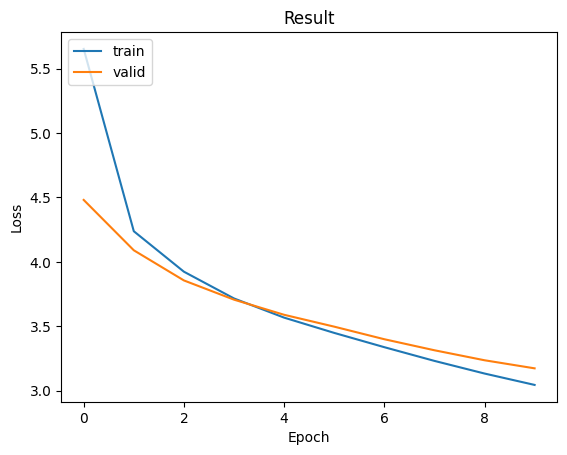

In [13]:
import torch.optim as optim
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, epochs, train_loader, valid_loader, model, optimizer, device = None, scheduler=None, early_stopping = 10, save_name = 'model.ckpt'):
        # 總訓練次數
        self.epochs = epochs

        # 訓練用資料
        self.train_loader = train_loader
        self.valid_loader = valid_loader

        # 優化方式
        self.optimizer = optimizer # 優化器
        self.scheduler = scheduler # 排程器(用於動態調整學習率)
        self.early_stopping = early_stopping # 防止模型在驗證集上惡化

        # 若沒輸入自動判斷裝置環境
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        # 宣告訓練用模型
        self.model = model.to(self.device)

        # 模型儲存名稱
        self.save_name = save_name

    def train_epoch(self, epoch):
        train_loss = 0
        train_pbar = tqdm(self.train_loader, position=0, leave=True)  # 進度條

        self.model.train()
        for input_datas in train_pbar:
            for optimizer in self.optimizer:
                optimizer.zero_grad()

            input_datas = {k: v.to(self.device) for k, v in input_datas.items()} # 將資料移動到GPU上
            outputs = self.model(**input_datas) # 進行前向傳播
            loss = outputs[0] # 取得損失值
            loss.backward() # 反向傳播

            # optimizer 可能有數個
            for optimizer in self.optimizer:
                optimizer.step()

            # scheduler 可能有數個
            if self.scheduler is not None:
                for scheduler in self.scheduler:
                    scheduler.step()


            postfix_dict = {'loss': f'{loss.item():.3f}'} # 定義進度條尾部顯示的資料
            train_pbar.set_description(f'Train Epoch {epoch}')  # 進度條開頭
            train_pbar.set_postfix(postfix_dict)                # 進度條結尾

            train_loss += loss.item()  # 加總損失值

        return train_loss / len(self.train_loader) # 計算平均損失


    def validate_epoch(self, epoch):
        valid_loss = 0
        valid_pbar = tqdm(self.valid_loader, position=0, leave=True)

        self.model.eval()     # 將模型轉換成評估模式
        with torch.no_grad(): # 防止梯度計算
            for input_datas in valid_pbar:
                input_datas = {k: v.to(self.device) for k, v in input_datas.items()}

                outputs = self.model(**input_datas)
                loss = outputs[0]

                valid_pbar.set_description(f'Valid Epoch {epoch}')
                valid_pbar.set_postfix({'loss':f'{loss.item():.3f}'})

                valid_loss += loss.item()

        return valid_loss / len(self.valid_loader)

    def train(self, show_loss=True):
        best_loss = float('inf')
        loss_record = {'train': [], 'valid': []}
        stop_cnt = 0
        for epoch in range(self.epochs):
            train_loss = self.train_epoch(epoch)
            valid_loss = self.validate_epoch(epoch)

            loss_record['train'].append(train_loss) # 加入訓練的平均損失
            loss_record['valid'].append(valid_loss) # 加入驗證的平均損失

            # 儲存最佳的模型
            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(self.model.state_dict(), self.save_name) # 儲存模型
                print(f'Saving Model With Loss {best_loss:.5f}')
                stop_cnt = 0
            else:
                stop_cnt += 1

            # Early stopping
            if stop_cnt == self.early_stopping:
                output = "Model can't improve, stop training"
                print('-' * (len(output) + 2))
                print(f'|{output}|')
                print('-' * (len(output) + 2))
                break

            print(f'Train Loss: {train_loss:.5f}', end='| ')
            print(f'Valid Loss: {valid_loss:.5f}', end='| ')
            print(f'Best Loss: {best_loss:.5f}', end='\n\n')

        # 顯示訓練曲線圖
        if show_loss:
            self.show_training_loss(loss_record)

    def show_training_loss(self, loss_record):
            train_loss, valid_loss = [i for i in loss_record.values()]

            plt.plot(train_loss)
            plt.plot(valid_loss)
            # 標題
            plt.title('Result')
            # Y軸座標
            plt.ylabel('Loss')
            # X軸座標
            plt.xlabel('Epoch')
            # 顯示各曲線名稱
            plt.legend(['train', 'valid'], loc='upper left')
            # 顯示曲線
            plt.show()

# 主程式部分
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 256
encoder = EncoderGRU(
    vocab_size=len(src_tokenizer),
    hidden_size=hidden_size,
    padding_idx=src_tokenizer.pad_token_id
)

decoder = DecoderGRU(
    attention = BahdanauAttention(hidden_size=hidden_size),
    hidden_size=hidden_size,
    output_size=len(tgt_tokenizer),
    padding_idx=tgt_tokenizer.pad_token_id
)

model = Attentionseq2seq(
    encoder = encoder,
    decoder = decoder,
    padding_idx = tgt_tokenizer.pad_token_id
).to(device)

optimizer_e = optim.Adam(encoder.parameters(), lr=1e-4)
optimizer_d = optim.Adam(decoder.parameters(), lr=1e-4)
trainer = Trainer(
    epochs=10,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=[optimizer_e, optimizer_d],
    early_stopping=3
)
trainer.train()


In [14]:
model.load_state_dict(torch.load('model.ckpt'))
model.eval()
x_valid[0] = "今天天氣很好"
for idx in range(3):
    input_ids = src_tokenizer(x_valid[idx], max_length=256, truncation=True, padding="longest", return_tensors='pt').to(device).input_ids[:, 1:]
    generated_ids = model.generate(input_ids, max_len=20)
    print('\n輸入文字:', x_valid[idx])
    print('目標文字:', y_valid[idx])
    print('翻譯文字:', tgt_tokenizer.decode(generated_ids))



輸入文字: 今天天氣很好
目標文字: He wants affection.
翻譯文字: [CLS] it ' s a good time. [SEP]

輸入文字: 別再讓我做那事了。
目標文字: Don't make me do that again.
翻譯文字: [CLS] tom is not to me. [SEP]

輸入文字: 我們愛湯姆。
目標文字: We love Tom.
翻譯文字: [CLS] tom is a good. [SEP]
